<a href="https://colab.research.google.com/github/jysung1122/aiModel/blob/main/%EC%9E%90%EC%9C%A8%EC%A3%BC%ED%96%89%ED%83%90%EC%A7%80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#자율주행(차량, 사람, 신호등, 자전거 등) 탐지모델
## 2024년 05월 08일 - 성재용

## 자율주행 탐지 모델이란?
    1. 자율주행 탐지 모델의 주요 목표는 주변 환경을 정확하게 인식
    2. 이를 위해 주행 보행자, 자전거, 차량, 신호등 등 다양한 객체를 탐지할 수 있어야 함
    

## 자율주행 탐지를 위한 데이터 세트
    1. https://public.roboflow.com/object-detection/self-driving-car
## 사용 AI 모델
    - yoloV5
        . 가장 빠른 인식률로 실시간 탐지에 유리 하다.
        . CNN 알고리즘 중 가장 활발하게 연구활동이 이루어지고 있다.

## AI 응용 SW를 개발하는 5단계
    1. What? 내가 어떤 모델을 개발할것인지
    2. DataSet을 준비 한다. - 양질의 DataSet은 SW 품질을 좌우한다.
    3. 적합한 Pre-Trained된 AI 모델을 선택한다.

    - 오늘 공부할 내용
    4. Fine-Tunning : 2에서 준비한 dataSet을 이용해서 3을 Customizinig 한다.
    
    - 마지막으로
    5. 응용 SW를 제작한다.
        . webAPP - 이전에 실습했던 TM을 기억한다.
        . nativeAPP - python과 pyQT로 작성했던 기억.

## 1. YOLO Clon from github


### 작업 폴더를 준비 하고 이동한다.

In [ ]:
%cd /content


###github에서 복사해오기

In [ ]:
!git clone https://github.com/ultralytics/yolov5

###개발환경을 install한다.
pothole에서는 빠졌던 부분

In [ ]:
%pwd

In [ ]:
%cd /content/yolov5
%pip install -r requirements.txt

## 2. 데이터세트 가져오기
위치는 https://public.roboflow.com/object-detection/self-driving-car

In [ ]:
#폴더를 만든다
%mkdir /content/yolov5/self_driving
%cd /content/yolov5/self_driving

In [ ]:
!curl -L "https://public.roboflow.com/ds/l71eccBLbu?key=0ggLL12kwa" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

###원본 dataSet의 구조를 알아보기 **참고1

In [ ]:
%cat /content/yolov5/self_driving/data.yaml

### 데이터의 구성을 확인한다.

In [ ]:
from glob import glob
train_img_list = glob('/content/yolov5/self_driving/export/images/*.jpg')
test_img_list = glob('/content/yolov5/self_driving/export/images/*.jpg')
valid_img_list = glob('/content/yolov5/self_driving/export/images/*.jpg')
print(len(train_img_list), len(test_img_list), len(valid_img_list))

glob은 해당 폴더의 파일 목록을 읽어와서 list로 저장하는 것이다.

###데이터 llist를 txt 파일로 만든다

In [ ]:
import yaml
with open('/content/yolov5/self_driving/train.txt','w') as f:
    f.write('\n'.join(train_img_list) + '\n')
with open('/content/yolov5/self_driving/test.txt','w') as f:
    f.write('\n'.join(test_img_list) + '\n')
with open('/content/yolov5/self_driving/val.txt','w') as f:
    f.write('\n'.join(valid_img_list) + '\n')

yaml은 "YAML Ain't Markup Language"의 약자로, 데이터를 저장하고 전달하기 위한 사람이 읽기 쉬운 데이터 직렬화 포맷입니다. 주로 설정 파일이나 데이터를 주고받을 때 사용되며, XML이나 JSON과 유사한 기능을 합니다. Python에서 yaml 모듈을 사용하려면, 먼저 PyYAML 패키지를 설치해야 합니다. 이 모듈을 사용하여 Python 데이터 구조를 YAML 형식의 문자열로 변환하거나, YAML 파일을 읽어 Python 데이터 구조로 변환할 수 있습니다.

예를 들어, Python 리스트나 딕셔너리를 YAML 문자열로 바꾸거나, 반대로 YAML 형식의 문자열을 Python 딕셔너리로 변환할 때 사용할 수 있습니다.

###프로그램 중에 사용할 함수를 정의합니다.
writetemplate이라는 함수

In [ ]:
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line,cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

### 이전에 확인했던 data.yaml의 내용을 수정합니다.
내용은 기존 내용중에 데이터의 위치를 수정

**참고1의 내용을 복사해서 경로만 수정함

In [ ]:
%%writetemplate /content/yolov5/self_driving/data.yaml

train: /content/yolov5/self_driving/export/images
val: /content/yolov5/self_driving/export/images

nc: 11
names: ['biker', 'car', 'pedestrian', 'trafficLight', 'trafficLight-Green', 'trafficLight-GreenLeft', 'trafficLight-Red', 'trafficLight-RedLeft', 'trafficLight-Yellow', 'trafficLight-YellowLeft', 'truck']

In [ ]:
%cat /content/yolov5/self_driving/data.yaml

### 파인튜닝된 모델에서 사용할 custom_yolov5s.yaml을 만들기

1. nc:3 이라고 적힌 것을 읽어서 변수에 저장
2. yolov5s.yaml의 내용을 cat으로 확인 하고 복사
3. writeTemplate 함수를 이용해서 새로 작성
   . nc:80 이라고 적힌 부분만
   . nc:{num_classes}라는 변수로 대체

   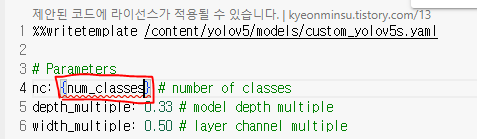

In [ ]:
import yaml

with open('/content/yolov5/self_driving/data.yaml','r') as stream:
  num_classes = str(yaml.safe_load(stream)['nc'])

print (f'num_classes: = {num_classes}')

%cat /content/yolov5/models/yolov5s.yaml

In [ ]:
%%writetemplate /content/yolov5/models/custom_yolov5s.yaml

# Parameters
nc: {num_classes} # number of classes
depth_multiple: 0.33 # model depth multiple
width_multiple: 0.50 # layer channel multiple
anchors:
  - [10, 13, 16, 30, 33, 23] # P3/8
  - [30, 61, 62, 45, 59, 119] # P4/16
  - [116, 90, 156, 198, 373, 326] # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [
    [-1, 1, Conv, [64, 6, 2, 2]], # 0-P1/2
    [-1, 1, Conv, [128, 3, 2]], # 1-P2/4
    [-1, 3, C3, [128]],
    [-1, 1, Conv, [256, 3, 2]], # 3-P3/8
    [-1, 6, C3, [256]],
    [-1, 1, Conv, [512, 3, 2]], # 5-P4/16
    [-1, 9, C3, [512]],
    [-1, 1, Conv, [1024, 3, 2]], # 7-P5/32
    [-1, 3, C3, [1024]],
    [-1, 1, SPPF, [1024, 5]], # 9
  ]

# YOLOv5 v6.0 head
head: [
    [-1, 1, Conv, [512, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, "nearest"]],
    [[-1, 6], 1, Concat, [1]], # cat backbone P4
    [-1, 3, C3, [512, False]], # 13

    [-1, 1, Conv, [256, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, "nearest"]],
    [[-1, 4], 1, Concat, [1]], # cat backbone P3
    [-1, 3, C3, [256, False]], # 17 (P3/8-small)

    [-1, 1, Conv, [256, 3, 2]],
    [[-1, 14], 1, Concat, [1]], # cat head P4
    [-1, 3, C3, [512, False]], # 20 (P4/16-medium)

    [-1, 1, Conv, [512, 3, 2]],
    [[-1, 10], 1, Concat, [1]], # cat head P5
    [-1, 3, C3, [1024, False]], # 23 (P5/32-large)

    [[17, 20, 23], 1, Detect, [nc, anchors]], # Detect(P3, P4, P5)
  ]

fine_tunning 모델에서 사용할
custom_yolov5s.yaml의 내용

아래 내용에서 꼭 확인 할것으 ㄴ
nc:3 이라는 점

In [ ]:
%cat /content/yolov5/models/custom_yolov5s.yaml

### 데이터 세트의 준비가 끝났습니다.

## 3. 학습

1. 학습에 사용되는 train.py는 gitclone했을때 생성되었으며
2. 코드 수정없이 다음 hyperParameter를 지정해서 사용한다.

하이퍼파라메타는 다음과 같다 .

    1. img: 원본 데이터의 이미지 크기 정의

    2. batch: 한번에 읽어들일 데이터의 수 배치 크기 결정

    3. epochs: 학습 기간 개수 정의.학습 반복 횟수

    4. data: data.yaml의 파일 경로

    5. cfg: 최종적으로 만들어지는 모델이 custom_yolov5s.yaml임을 지정

    6. weights: 가중치에 대한 경로 지정 이것은 여기서는 사용하지 않으나 transferLearning을 하는 경우 이전에 하던 작업을 이어받을 경우 최종 가중치 파일을 지정

    7. name: 결과 확인을 위한 이름

    8. cache: 빠른 학습을 위한 이미지 캐시 사용



### 학습시작

In [ ]:
%%time
%cd /content/yolov5/
!python train.py --img 512 --batch 16 --epochs 100 --data ./self_driving/data.yaml --cfg ./models/custom_yolov5s.yaml --weights '' --name _result --cache

### tensorBoard를 이용해서 결과 확인
현재 폴더는 틀림없이 yolov5이다

In [ ]:
%load_ext tensorboard
%tensorboard --logdir runs

### 우리가 최종적으로 갖게 되는 가중치 파일은

/content/yolov5/runs/train/_result/weights 폴더에

다음 2개의 파일이 있다.

best.pt - epoch중 가장 성능이 좋은 모델

last.pt - 가장 마지막에 만들어진 모델


그래서  best.pt를 내 컴퓨터 또는 구글 드라이브에 다운 로드하여 두기로 한다.

### 구글드라이브 연결하기

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### 복사해두기

In [ ]:
!cp /content/yolov5/runs/train/_result3/weights/best.pt /content/drive/MyDrive/yolov5Models/self_driving

## 4. Inference 성능시험
### 유튜브의 동영상을 다운로드해서 그 동영상내의 Object를 detection 할것이다.
그리고 결과는 mp4 파일로 저장한다.

### chatGPT를 이용해서 유튜브 동영상을 다운로드 받게 도움 받는다

동영상은 임의의 것으로 모델의 성능 평가에 적합한것을 사용

In [ ]:
!pip install -U yt-dlp
!yt-dlp -f 'best[ext=mp4]' --output "input_video.mp4" "https://www.youtube.com/watch?v=uewI_P_XjYc&ab_channel=%EC%95%84%EC%9D%B4%EB%82%98%EB%B9%84INAVI"


In [ ]:
%pwd

In [ ]:
!python detect.py --weights /content/yolov5/runs/train/_result3/weights/best.pt --img 640 --conf 0.25 --source input_video.mp4


### 동영상을 다운로드 받아서 확인 하세요

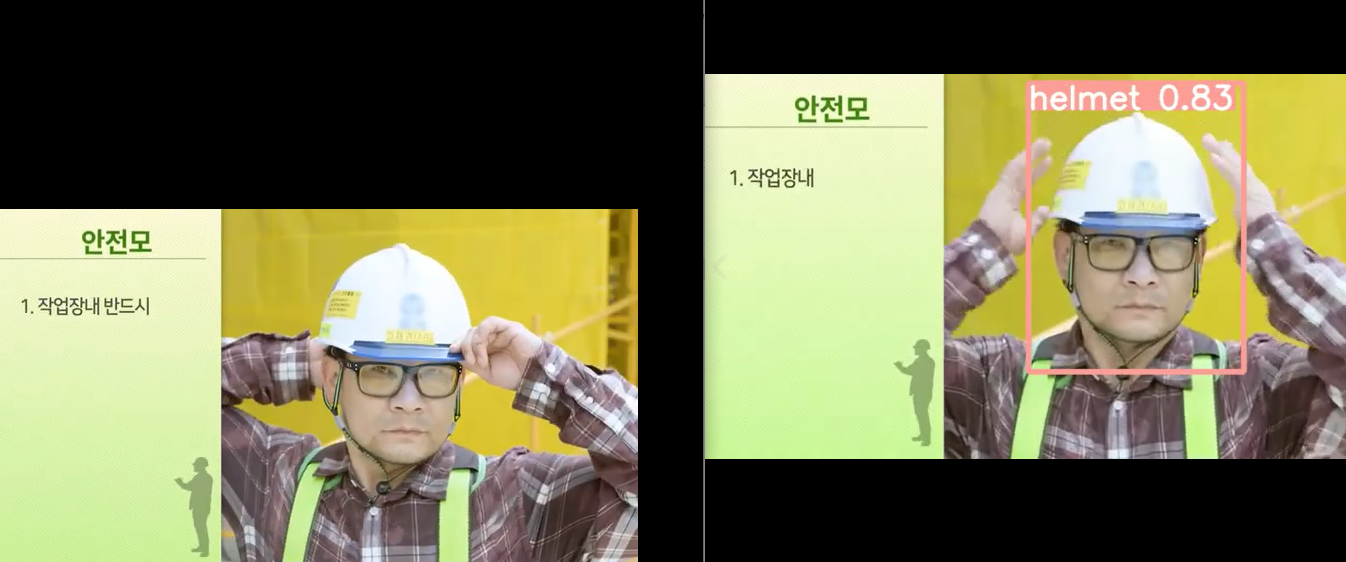

# 과제
### 1. 연기탐지 모델과
* 연기 데이터셋: https://public.roboflow.com/object-detection/wildfire-smoke/

### 2. 주차공간 모델을 완성하시오
* 주차공간 데이터셋: https://public.roboflow.com/object-detection/pklot

### 3. inference는 동영상을 다운로드 받아서 사용